In [59]:
import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

from obsrv_plan.general.params import DATA_FILE_PATH, MAX_PARALLEL, WORKING_DIR

from time import sleep
import requests
import csv

from multiprocessing import Pool, Lock

LOCK = Lock()
MAX_PARALLEL = 6

In [60]:
print(WORKING_DIR)

/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half


In [61]:
import math

def writeSplit(lines: list[str], header: str, split: int) -> str:
	splitFilePath = os.path.join(WORKING_DIR, f"{split}.csv")
	print(f"Writing split {split} to {splitFilePath}")
	with open(splitFilePath, 'w+') as splitFile:
		splitFile.write(header + "\n")
		splitFile.writelines(lines)
	print("Finished writing split")
	return splitFilePath

splitCsvFiles = []
totalNumRows = 3_630_000
split = math.ceil(totalNumRows / MAX_PARALLEL)
with open(DATA_FILE_PATH, 'r') as targetsCsv:
	isReadingHeader = True
	header: str
	curSplitLines = []
	curSplit = 0
	for lineList in csv.reader(targetsCsv):
		rawLine = ",".join(lineList) + '\n'
		if isReadingHeader:
			header = rawLine
			isReadingHeader = False
		else:
			curSplitLines.append(rawLine)

		if len(curSplitLines) == split:
			splitCsvFiles.append(writeSplit(curSplitLines, header, curSplit))
			curSplitLines.clear()
			curSplit += 1

if len(curSplitLines) != 0:
	splitCsvFiles.append(writeSplit(curSplitLines, header, curSplit))
splitCsvFiles

Writing split 0 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/0.csv
Finished writing split
Writing split 1 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/1.csv
Finished writing split
Writing split 2 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/2.csv
Finished writing split
Writing split 3 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/3.csv
Finished writing split
Writing split 4 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/4.csv
Finished writing split
Writing split 5 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/5.csv
Finished writing split
Writing split 6 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/6.csv
Finished writing split
Writing split 7 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/7.csv
Finished writing split
Writing split 8 to /home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/8.csv
Finished writin

['/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/0.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/1.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/2.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/3.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/4.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/5.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/6.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/7.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/8.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/9.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/10.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/11.csv',
 '/home/ramon/uanl/Tesis/Backup Data/Gaia Query Results/sdss-half/12.csv',
 '/home/ramon/uanl/Tesis/Backup Dat

In [62]:
def printSync(stringPrint: str) -> None:
	with LOCK:
		print(os.getpid(), stringPrint)

In [63]:
import io

from astropy.io.votable import parse_single_table

class StarRecord:

	def __init__(self, gaia_source_id: str, simbad_id: str, ra: float, dec: float, type: str) -> None:
		self.gaia_source_id = gaia_source_id
		self.simbad_id = simbad_id
		self.ra = ra
		self.dec = dec
		self.type = type

	def to_dict(self) -> dict[str, str]:
		return {
			"gaia_source_id": self.gaia_source_id,
			"simbad_id": self.simbad_id,
			"ra": str(self.ra),
			"dec": str(self.dec),
			"type": self.type
		}

	def __str__(self) -> str:
		return f"gid={self.gaia_source_id}, sid={self.simbad_id}, ra={self.ra}, dec={self.dec}, type={self.type}"
	
	def __repr__(self) -> str:
		return str(self)

def cleanLine(line):
	return line.replace("b'", "").replace("\\n'", "").replace("\\n", "\n")

def parseVotableToStarRecord(simbadVotRawStr: str, gaiaSourceId: str) -> StarRecord | None:
	try:		
		with io.BytesIO() as resultStream:
			line = cleanLine(simbadVotRawStr)
			resultStream.write(bytes(line, "utf-8"))
			vot = parse_single_table(resultStream)
		for starCandidate in vot.array:
			starId = starCandidate[2]
			starType = starCandidate[3]
			
			return StarRecord(gaia_source_id=gaiaSourceId, simbad_id=starId, ra=starCandidate[4], dec=starCandidate[5], type=starType)
	except Exception as e:
		printSync(f"Error parsing: {str(e)}")

In [67]:
def querySimbad(ra, dec) -> bytes:
	SIMBAD_QUERY_URL = "http://simbad.u-strasbg.fr/simbad/sim-coo"
	
	params = {
		'Coord': f"{ra} {dec}",
		'Radius': 2,
		'Radius.unit': "arcmin",
		'output.format': "VOTable"
	}

	triesRemaining = 3
	result = None
	while True:
		try:
			result = requests.get(url=SIMBAD_QUERY_URL, params=params)
			break
		except Exception:
			if triesRemaining == 0:
				printSync(f"Out of tries for ({ra}, {dec}). Skipping.")
				break
			else:
				triesRemaining -= 1
				printSync(f"Error querying for ({ra}, {dec}). Retrying {triesRemaining} more times.")
				sleep(2)
	return result.content

def processSources(starRows) -> list[StarRecord]:
	RA_PROP = "J2000_ra_prop"
	DEC_PROP = "J2000_dec_prop"
	SOURCE_ID_PROP = "source_id"

	RA_COL_POS 	= -1
	DEC_COL_POS	= -1
	SOURCE_ID_COL_POS = -1

	allStarRecords = []

	objCount = 0 # only used to track if the header has been seen
	for star in starRows:
		# getting column positions from header
		if objCount == 0:
			RA_COL_POS = star.index(RA_PROP)
			DEC_COL_POS = star.index(DEC_PROP)
			SOURCE_ID_COL_POS = star.index(SOURCE_ID_PROP)
			objCount = 1
			continue
		if len(star) == 0: # empty row
			printSync("Skipping empty row")
			continue

		if objCount % 100 == 0:
			printSync(f"Processed {objCount} objects")

		ra = star[RA_COL_POS]
		dec = star[DEC_COL_POS]
		sourceId = star[SOURCE_ID_COL_POS]

		votRawStr = str(querySimbad(ra, dec))
		starRecord = parseVotableToStarRecord(votRawStr, sourceId)

		if starRecord is not None:
			allStarRecords.append(starRecord)

		objCount += 1
	return allStarRecords

In [ ]:
def multiProcessSources(sourcesCsvFilePath: str):
	with LOCK:
		print(os.getpid(), sourcesCsvFilePath)
	with open(sourcesCsvFilePath, 'r') as file:
		# starRows = []
		# for record in csv.reader(file):
		# 	if len(starRows) == 6:
		# 		break
		# 	starRows.append(record)

		starRows = csv.reader(file)
		try:
			return processSources(starRows)
		except Exception as e:
			with LOCK:
				print(sourcesCsvFilePath, e)
			raise e

with Pool(MAX_PARALLEL) as p:
	resultLists = p.map(multiProcessSources, splitCsvFiles)

simbadStars = [item for sublist in resultLists for item in sublist]
# simbadStars

In [ ]:
categories = {}
for starRecord in simbadStars:
	starTypeList = categories.get(starRecord.type, [])
	starTypeList.append(starRecord.to_dict())
	categories[starRecord.type] = starTypeList

# categories

In [ ]:
import json

starCategoriesJson = os.path.join(WORKING_DIR, "categories.json")
with open(starCategoriesJson, 'w+') as file:
	json.dump(categories, file)

In [ ]:
{cat:len(records) for cat, records in categories.items()}

{'Star': 11,
 'LongPeriodV*_Candidate': 3,
 'LongPeriodV*': 6,
 'RRLyrae': 2,
 'SB*': 1,
 'Radio': 1,
 'FarIR': 1,
 'EclBin_Candidate': 1,
 'Galaxy': 2}

In [14]:
# alternative histogram; using outdated data
import os
import json

outdatedCategoriesJsonPath = "/run/media/ramon/ROG_Data/Tesis/Gaia Analisis/20221119/desired-categories/categoriesHistogram.json"
with open(outdatedCategoriesJsonPath, 'r') as file:
	outdatedCategoryCounts = json.load(file)

categoryCounts = [(cat, count) for cat, count in outdatedCategoryCounts.items()]
categories = [cat for cat, _ in categoryCounts]
counts = [count for _, count in categoryCounts]
categoryCounts

[('Variable*', 173),
 ('Mira', 329),
 ('LongPeriodV*', 213),
 ('EclBin_Candidate', 27),
 ('Star', 1471),
 ('Low-Mass*', 1),
 ('Galaxy', 29),
 ('LongPeriodV*_Candidate', 323),
 ('AGN', 1),
 ('Mira_Candidate', 2),
 ('S*', 26),
 ('YSO_Candidate', 116),
 ('RRLyrae_Candidate', 10),
 ('WhiteDwarf_Candidate', 47),
 ('EclBin', 12),
 ('Infrared', 35),
 ('AGB*', 10),
 ('QSO', 1),
 ('Radio', 92),
 ('RedSG', 3),
 ('HighPM*', 39),
 ('C*', 50),
 ('SB*', 42),
 ('CataclyV*', 1),
 ('X', 16),
 ('FarIR', 29),
 ('RGB*', 45),
 ('UV', 2),
 ('DarkNeb', 41),
 ('HIshell', 4),
 ('PulsV*', 26),
 ('HorBranch*', 14),
 ('MolCld', 27),
 ('**', 20),
 ('ClassicalCep', 12),
 ('Association', 4),
 ('HIIReg', 5),
 ('Blend', 4),
 ('WhiteDwarf', 2),
 ('GroupG', 1),
 ('EmLine*', 22),
 ('Be*', 6),
 ('C*_Candidate', 21),
 ('Maser', 2),
 ('MidIR', 3),
 ('ISM', 3),
 ('SNRemnant', 2),
 ('OH/IR*', 2),
 ('YSO', 205),
 ('BrownD*_Candidate', 4),
 ('PartofCloud', 4),
 ('smmRad', 3),
 ('ChemPec*', 1),
 ('gammaBurst', 3),
 ('BlueStraggl

In [27]:
trimmedCategories = {"Misc.": 0}
for cat, count in categoryCounts:
	if count < 10:
		trimmedCategories["Misc."] += count
	else:
		trimmedCategories[cat] = count

categoryCounts = [(cat, count) for cat, count in trimmedCategories.items()]
categories = [cat for cat, _ in categoryCounts]
counts = [count for _, count in categoryCounts]

In [25]:
categoryCounts, categories

([('Misc.', 86),
  ('Variable*', 173),
  ('Mira', 329),
  ('LongPeriodV*', 213),
  ('EclBin_Candidate', 27),
  ('Star', 1471),
  ('Galaxy', 29),
  ('LongPeriodV*_Candidate', 323),
  ('S*', 26),
  ('YSO_Candidate', 116),
  ('RRLyrae_Candidate', 10),
  ('WhiteDwarf_Candidate', 47),
  ('EclBin', 12),
  ('Infrared', 35),
  ('AGB*', 10),
  ('Radio', 92),
  ('HighPM*', 39),
  ('C*', 50),
  ('SB*', 42),
  ('X', 16),
  ('FarIR', 29),
  ('RGB*', 45),
  ('DarkNeb', 41),
  ('PulsV*', 26),
  ('HorBranch*', 14),
  ('MolCld', 27),
  ('**', 20),
  ('ClassicalCep', 12),
  ('EmLine*', 22),
  ('C*_Candidate', 21),
  ('YSO', 205)],
 ['Misc.',
  'Variable*',
  'Mira',
  'LongPeriodV*',
  'EclBin_Candidate',
  'Star',
  'Galaxy',
  'LongPeriodV*_Candidate',
  'S*',
  'YSO_Candidate',
  'RRLyrae_Candidate',
  'WhiteDwarf_Candidate',
  'EclBin',
  'Infrared',
  'AGB*',
  'Radio',
  'HighPM*',
  'C*',
  'SB*',
  'X',
  'FarIR',
  'RGB*',
  'DarkNeb',
  'PulsV*',
  'HorBranch*',
  'MolCld',
  '**',
  'Classica

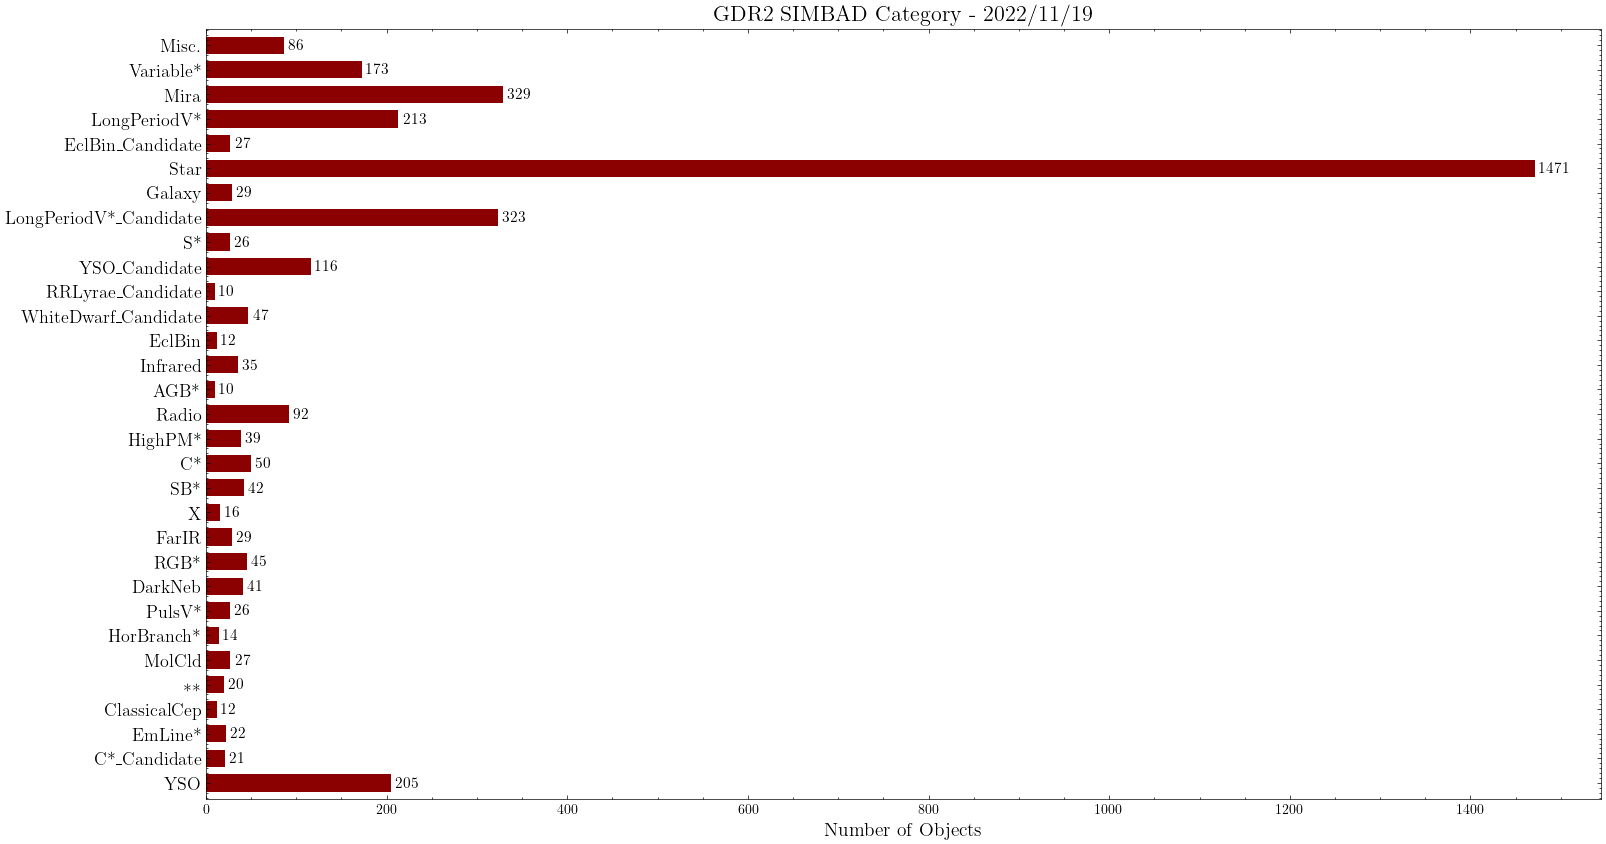

In [43]:
import matplotlib.pyplot as plt
import numpy as np

import scienceplots
plt.style.use("science")

fig, ax = plt.subplots(figsize=(18, 10))

# y_pos = np.arange(len(categories.keys()))
y_pos = np.arange(len(categories))

# hbars = ax.barh(y_pos, list(map(lambda v: len(v), categories.values())), align='center')
hbars = ax.barh(categories, counts, align='center', color="darkred", height=0.7)
# ax.set_yticks(y_pos, labels=categories.keys(), fontsize=11)
ax.set_yticks(y_pos, labels=categories, fontsize=13)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Objects', fontsize=14)
# ax.set_title('GDR2 SIMBAD Category', fontsize=16)
ax.set_title('GDR2 SIMBAD Category - 2022/11/19', fontsize=16)
ax.bar_label(hbars, padding=3, fontsize=11)
ax.set_ymargin(0.01)
plt.show()